<h2 style="color:green">Seting up</h2>

In [1]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


In [124]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 60  # Number of epochs we usually start to train with
BATCH_SIZE = 512  #

In [3]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
10474,@USAirways you're right it's not fun. Especial...,negative
13703,@AmericanAir can you please connect these two ...,neutral
2153,@united our 1 layover itinerary was swapped fo...,negative
6531,@SouthwestAir knows whats up! That #BlackHisto...,positive
13131,@AmericanAir @USAirways you can help by now fi...,negative


<h2 style="color:green">Pre-paring Data</h2>

In [4]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

In [5]:
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

In [6]:
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
10474,right not fun. Especially much choice. Lol. #...,negative
13703,please connect two reservations together also...,neutral
2153,layover itinerary swapped layover itinerary r...,negative
6531,knows whats up! That #BlackHistoryMonth comme...,positive
13131,help finding baggage!! Reply ASAP direct det...,negative


In [49]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


In [61]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [50]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ", 
               char_level=False)
tk.fit_on_texts(X_train)


In [78]:
tk.word_index['friend']

538

In [69]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

# print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

In [64]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[471, 896, 80, 13, 621, 874, 4, 45, 215, 1, 4310, 1415, 127, 244, 548]" is converted into [0. 1. 0. ... 0. 0. 0.]
For this example we have 15.0 features with a value of 1.


In [81]:
X_train_oh.shape

(13176, 10000)

In [100]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[2], y_train_le[1]))
print('"{}" is converted into {}'.format(y_train_le[1], y_train_oh[1]))

"negative" is converted into 0
"0" is converted into [1. 0. 0.]


In [83]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


In [88]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [125]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [92]:
base_model.compile(optimizer='rmsprop'
              , loss='categorical_crossentropy'
              , metrics=['accuracy'])

history = base_model.fit(X_train_rest
                   , y_train_rest
                   , epochs=NB_START_EPOCHS
                   , batch_size=BATCH_SIZE
                   , validation_data=(X_valid, y_valid)
                   , verbose=0)

In [118]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

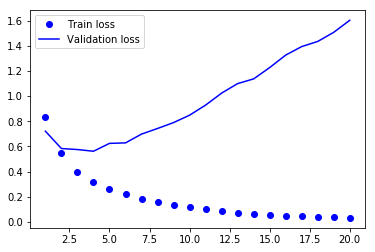

In [119]:
eval_metric(base_history, 'loss')

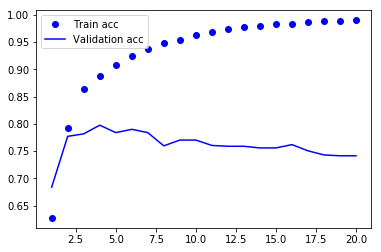

In [120]:
eval_metric(base_history, 'acc')

In [121]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [127]:
reduced_history = deep_model(reduced_model)

In [116]:
sent = "i liked it"
sent = one_hot_seq(tk.texts_to_sequences([sent]))[0]
print(sent)
sent = np.reshape(sent, (1, 10000))
base_model.predict(sent)

[0. 0. 0. ... 0. 0. 0.]


array([[9.7219896e-01, 2.7714465e-02, 8.6549015e-05]], dtype=float32)

In [153]:
sent = "e"
sent = one_hot_seq(tk.texts_to_sequences([sent]))[0]
print(sent)
sent = np.reshape(sent, (1, 10000))
reduced_model.predict(sent)

[0. 0. 1. ... 0. 0. 0.]


array([[0.51032835, 0.48818335, 0.00148823]], dtype=float32)

In [157]:
X_train[0]
y_train[0]

'positive'